In [1]:
import tensorflow as tf
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt

%matplotlib inline

def featureNormalise(X):
    mu = np.mean(X,0)
    sigma = np.std(X,0, ddof=1)
    return ((X - mu) / sigma), mu, sigma

def mapFeatures(x1, x2):
    degree = 6;
    out = np.ones([x1.shape[0],1]);
    for i in range(1, degree+1):
        for j in range(0, i+1):
            out = np.hstack((out,np.array((x1**(i-j)) * (x2**j)).reshape(x1.shape[0],1)))
    return out


## Load Training data
dataset = pandas.read_csv("data/ex4data1_X.csv", header=None)
labels = pandas.read_csv("data/ex4data1_y.csv", header=None)

m,n = dataset.shape
X = dataset.values.reshape(m,n).astype(np.float32)
y_raw = labels.values.ravel() - 1

## Load Validation and Test data

## Normalise - Already Normalised for this dataset
x_norm = X#, mu, sigma = featureNormalise(X)

# Add bias
x_with_bias = np.hstack((np.ones((x_norm.shape[0],1)),x_norm)).astype(np.float32)
#x_with_bias = mapFeatures(x_norm[:,0], x_norm[:,1]).astype(np.float32)
#m,n = x_with_bias.shape

In [2]:
import pandas as pd
##
## Split (Train/Val/Test)
##
def split(data, train=.6, val=.2, test=.2):
    idx = np.arange(0,len(data)) / float(len(data))
    msk1 = data[idx<train]
    msk2 = data[(idx>=train) & (idx<(train + val))]
    msk3 = data[(idx>=(train+val))]
    return [msk1.values, msk2.values, msk3.values]

##
## Shuffle data
##
def shuffle(data):
    return data.sample(frac=1).reset_index(drop=True)

def encode(data):
    y = np.zeros([data.shape[0], 10]).astype(np.float32)
    for i in range(0,data.shape[0]):
        y[i,data[i]] = 1.
    return y

shuffled = shuffle(pd.DataFrame(np.hstack((x_with_bias,y_raw.reshape(m,1)))))
train_X, val_X, test_X = split(shuffled)
train_y = encode(train_X[:,-1].reshape(-1,1).astype(np.integer))
val_y = encode(val_X[:,-1].reshape(-1,1).astype(np.integer))
test_y = encode(test_X[:,-1].reshape(-1,1).astype(np.integer))


In [3]:

# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
HIDDEN_UNITS = 25
NUM_FEATURES = 400
NUM_LABELS = 10
# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32, shape=(None, NUM_FEATURES+1))
train_labels_node = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
lam = tf.placeholder(tf.float32)

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized. 
# TODO : These should be pulled from a config file

Theta1 = tf.Variable( tf.truncated_normal([HIDDEN_UNITS, (NUM_FEATURES+1)], stddev=0.1, seed=SEED))

Theta2 = tf.Variable( tf.truncated_normal([NUM_LABELS, HIDDEN_UNITS],stddev=0.1, seed=SEED))
bias2 = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))
    
print('Done')

Done


In [4]:
def model(X, Theta1, Theta2, bias):
    """The Model definition."""
    # Perceptron
    
    layer1 = tf.nn.sigmoid(tf.matmul(X, tf.transpose(Theta1)))
                        
    output = tf.nn.bias_add(tf.matmul(layer1, tf.transpose(Theta2)),bias)

    return output
    
print('Done')

Done


In [5]:
yhat = model(train_data_node, Theta1, Theta2, bias2)

# Change the weights by subtracting derivative with respect to that weight
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=train_labels_node, logits=yhat))
# Regularization using L2 Loss function 
regularizer = tf.nn.l2_loss(Theta1) + tf.nn.l2_loss(Theta2)
loss_reg = loss + (lam / tf.to_float(tf.shape(train_labels_node)[0])) * regularizer

# Optimizer: 

# Gradient Descent
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss_reg, options={'maxiter':500})
#update_weights = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Predictions
train_prediction = yhat

print('Done')

Done


In [6]:
def train(feed_dict, train=True):
    
    #optimizer.minimize(feed_dict=feed_dict, fetches=[loss_reg], loss_callback=loss_callback)
    if (train):
        optimizer.minimize(feed_dict=feed_dict)

    return loss.eval(feed_dict)

Training with 0 training examples
Training with 500 training examples
Training with 1000 training examples
Training with 1500 training examples
Training with 2000 training examples
Training with 2500 training examples
Training with 3000 training examples


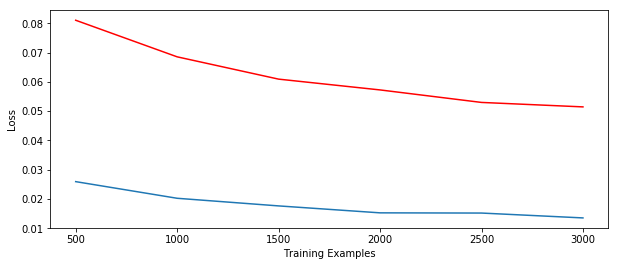

In [7]:
###
### LEARNING CURVES FOR TRAINING SET AND CROSS-VALIDATION SET 
###
train_losses = []
val_losses = []
tf.logging.set_verbosity(tf.logging.ERROR)

for i in range(0,train_X.shape[0]+1,500):
    # Create a new interactive session that we'll use in
    # subsequent code cells.
    s = tf.InteractiveSession()

    # Initialize all the variables we defined above.
    tf.global_variables_initializer().run()
    
    myLam = 0.1

    print("Training with %s training examples" % i)
    train_losses.append(train({train_data_node: train_X[:i,:NUM_FEATURES+1], train_labels_node: train_y[:i,:], lam: myLam}))
    val_losses.append(train({train_data_node: val_X[:i,:NUM_FEATURES+1], train_labels_node: val_y[:i,:], lam: myLam}, train=False))

    
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(val_losses))) *500
ax1.plot(x, np.array(train_losses).ravel())
ax1.plot(x, np.array(val_losses).ravel(),'r')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

Training with lambda : 0.0
Training with lambda : 0.001
Training with lambda : 0.003
Training with lambda : 0.01
Training with lambda : 0.03
Training with lambda : 0.1
Training with lambda : 0.3
Training with lambda : 1.0
Training with lambda : 3.0
Training with lambda : 10.0
Optimal value for lambda is 0.1


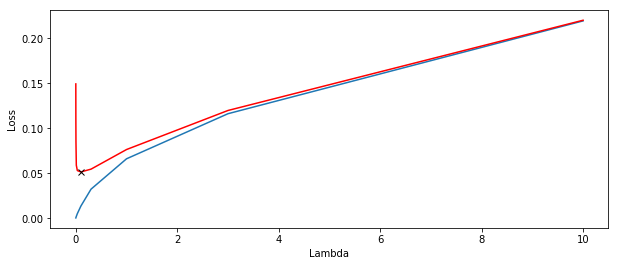

In [8]:
###
### VALIDATION CURVES FOR OPTIMISING TO VALIDATION SET
###
train_losses = []
val_losses = []
tf.logging.set_verbosity(tf.logging.ERROR)

lams = [0.0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

for i in lams:
    # Create a new interactive session that we'll use in
    # subsequent code cells.
    s = tf.InteractiveSession()

    # Initialize all the variables we defined above.
    tf.global_variables_initializer().run()
    
    print("Training with lambda : %s" % i)
    
    train_losses.append(train({train_data_node: train_X[:,:NUM_FEATURES+1], train_labels_node: train_y[:,:], lam: i}))
    val_losses.append(train({train_data_node: val_X[:,:NUM_FEATURES+1], train_labels_node: val_y[:,:], lam: i}, train=False))

lam_opt = lams[np.argmin(val_losses)]
print("Optimal value for lambda is %s" % lam_opt)
    
# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.plot(lams, np.array(train_losses).ravel())
ax1.plot(lams, np.array(val_losses).ravel(),'r')
ax1.plot(lams[np.argmin(val_losses)], val_losses[np.argmin(val_losses)], 'x', color='black')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Lambda")
plt.show()

In [9]:
### 
### PREDICTIONS
###
tf.logging.set_verbosity(tf.logging.ERROR)

# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Initialize all the variables we defined above.
tf.global_variables_initializer().run()

train({train_data_node: train_X[:,:NUM_FEATURES+1], train_labels_node: train_y[:,:], lam: lam_opt})

def predict(data_X, data_y, lam1):    
    predictions = train_prediction.eval({train_data_node: data_X, train_labels_node: data_y, lam: lam1})
    a = np.argmax(predictions,axis=1) 
    return np.float32(np.sum(a == np.argmax(data_y, axis=1)) / np.float32(data_X.shape[0]))
    
print("Training Set accuracy : %.2f%%" % (predict(train_X, train_y, lam_opt)*100))
print("Validation Set accuracy : %.2f%%" % (predict(val_X, val_y, lam_opt)*100))
print("Test Set accuracy : %.2f%%" % (predict(test_X, test_y, lam_opt)*100))

Training Set accuracy : 99.67%
Validation Set accuracy : 93.10%
Test Set accuracy : 91.80%
